In [1]:
from imports import *
import get_tess_data as gtd
import median_detrend as mdt 
import transitleastsquares as tls

# get TESS data

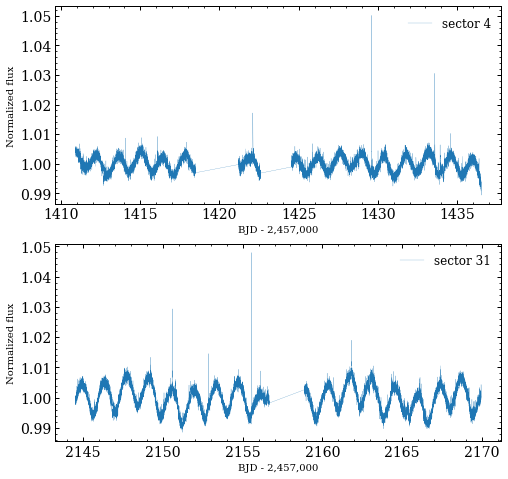

In [3]:
# read-in data from MAST
tic = 98796344
kwargs = {'use_20sec': False, 'minsector': 4, 'maxsector': 31}
bjd,fnorm,efnorm,sectors,qual_flags,texps = gtd.read_TESS_data(tic, **kwargs)

# plot
plt.figure(figsize=(8,len(np.unique(sectors))*4))
for i,s in enumerate(np.unique(sectors)):
    g = sectors == s
    plt.subplot(len(np.unique(sectors)),1,i+1)
    plt.plot(bjd[g]-2457e3, fnorm[g], '-', lw=.2, label='sector %i'%s)
    plt.xlabel('BJD - 2,457,000'), plt.ylabel('Normalized flux'), plt.legend(fontsize=12)

# detrend the light curve

RMS(raw flux sector 4)		= 2.549 ppt
RMS(detrended flux sector 4)	= 1.059 ppt
RMS(raw flux sector 31)		= 4.128 ppt
RMS(detrended flux sector 31)	= 1.056 ppt


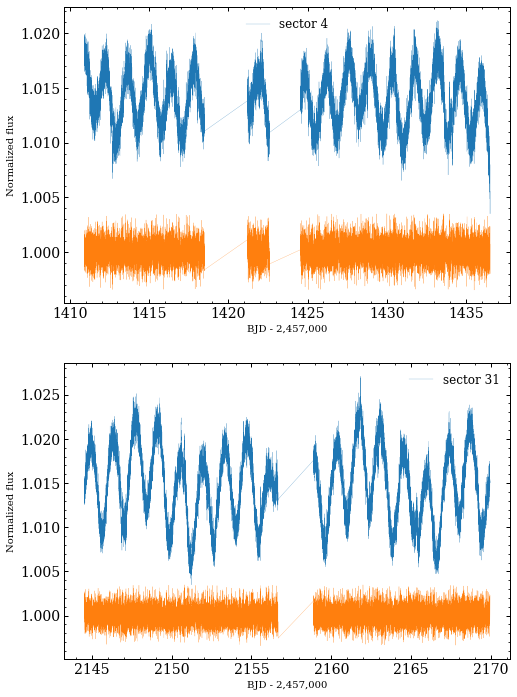

In [4]:
# detrend with GP or median filter
use_exo = 0

if use_exo:
    bjd, fdetrend, efnorm, model, map_soln, extras = dlc.detrend_light_curve(bjd, fnorm, efnorm)
    
else:
    window_length = 12/24   # length of window in days
    fdetrend, mask = mdt.detrend_all_sectors(bjd, fnorm, sectors, window_length_days=window_length)
    bjd, fnorm, fdetrend, efnorm, sectors = np.vstack([bjd,fnorm,fdetrend,efnorm,sectors]).T[mask].T
    
# plot
plt.figure(figsize=(8,len(np.unique(sectors))*6))
for i,s in enumerate(np.unique(sectors)):
    g = sectors == s
    plt.subplot(len(np.unique(sectors)),1,i+1)
    plt.plot(bjd[g]-2457e3, fnorm[g]+(fdetrend[g].max() - fnorm[g].min()), '-', lw=.2, label='sector %i'%s)
    plt.plot(bjd[g]-2457e3, fdetrend[g], '-', lw=.2)
    _=plt.xlabel('BJD - 2,457,000'), plt.ylabel('Normalized flux'), plt.legend(fontsize=12)
    print('RMS(raw flux sector %i)\t\t= %.3f ppt'%(s,np.std(fnorm[g]*1e3)))
    print('RMS(detrended flux sector %i)\t= %.3f ppt'%(s,np.std(fdetrend[g]*1e3)))

In [19]:
## make noise only LC
fnoise = np.zeros_like(bjd)
for s in np.unique(sectors):
    g = sectors == s
    fnoise[g] = np.random.randn(g.sum()) * np.nanstd(fdetrend[g])

# run TLS

In [88]:
def run_tls(bjd, fdetrend, efnorm, ab, results=[]):
    model = tls.transitleastsquares(bjd, fdetrend, efnorm)
    results = model.power(u=ab, period_min=.5, period_max=15)
    return results



def mask_transits(bjd, fdetrend, efnorm, results):
    intransit = tls.transit_mask(bjd, results['period'], 2*results['duration'], results['T0'])
    fdetrend_2 = fdetrend[~intransit]
    efnorm_2 = efnorm[~intransit]
    bjd_2 = bjd[~intransit]
    bjd_2, fdetrend_2, efnorm_2 = tls.cleaned_array(bjd_2, fdetrend_2, efnorm_2)
    return bjd_2, fdetrend_2, efnorm_2



def plot_sde_spectrum(results):
    '''
    Plot the results of a TLS search: i.e. the signal detection efficiency versus period (marginalized 
    over phase and transit duration).
    '''
    plt.figure(figsize=(8,6))
    plt.axvline(results['period'], alpha=0.4, lw=3)
    plt.xlim(np.min(results['periods']), np.max(results['periods']))
    for n in range(2, 10):
        plt.axvline(n*results['period'], alpha=0.4, lw=1, linestyle="dashed")
        plt.axvline(results['period'] / n, alpha=0.4, lw=1, linestyle="dashed")
    plt.ylabel('SDE'), plt.xlabel('Period [days]')
    plt.plot(results['periods'], results['power_raw'], color='black', lw=0.5)
    plt.xlim(0, max(results['periods']))
    
    
    
def plot_phasefolded_LC(results, ylim=()):
    plt.figure(figsize=(8,6))
    plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
    plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
    plt.xlim(.45,.55)
    if len(ylim):
        plt.ylim(ylim)
    plt.xlabel('Phase')
    plt.ylabel('Relative flux')

In [89]:
# get stellar parameters for the transit model
ab, mass, mass_min, mass_max, radius, radius_min, radius_max = tls.catalog_info(TIC_ID=tic)
mass, radius, ab

(array(0.249439), array(0.275953), (0.1555, 0.4459))

In [90]:
# define period and duration grid

In [20]:
# run the tls on the nosie-only LC 
results_noise_dict = {}
for s in np.unique(sectors):
    g = sectors == s
    results_noise_dict['%i'%s] = run_tls(bjd[g], fnoise[g], efnorm[g], ab)

/Users/ryancloutier/anaconda3/envs/myenv/lib/python3.8/site-packages/transitleastsquares/validate.py:31: UserWarning: Warning: The mean flux should be normalized to 1, but it was found to be 0.0008458369744375887
  warnings.warn(text)
  0%|          | 0/2309 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 7354 data points, 2309 periods from 0.601 to 12.804 days
Using all 8 CPU threads


100%|██████████| 2309/2309 periods | 00:23<00:00
/Users/ryancloutier/anaconda3/envs/myenv/lib/python3.8/site-packages/transitleastsquares/validate.py:31: UserWarning: Warning: The mean flux should be normalized to 1, but it was found to be 0.0008342837730053311
  warnings.warn(text)
  0%|          | 0/2289 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 37 durations
Searching 8214 data points, 2289 periods from 0.601 to 12.71 days
Using all 8 CPU threads


100%|██████████| 2289/2289 periods | 00:27<00:00


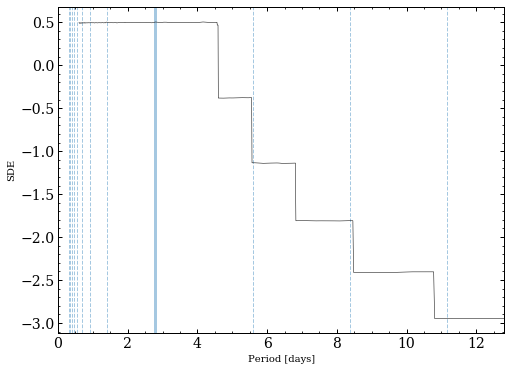

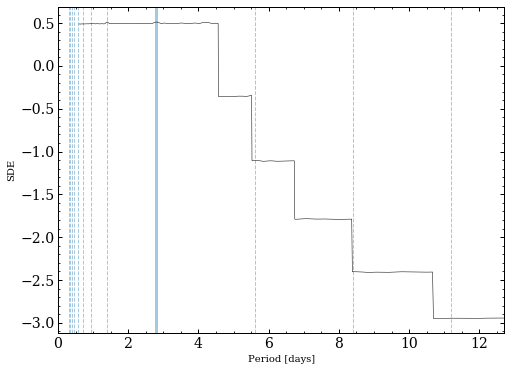

In [41]:
for s in np.unique(sectors):
    plot_sde_spectrum(results_noise_dict['%i'%s])

## planet search

In [91]:
# run the tls
results_1_dict = {}
for s in np.unique(sectors):
    g = sectors == s
    results_1_dict['%i'%s] = run_tls(bjd[g], fdetrend[g], efnorm[g], ab)

  0%|          | 0/2309 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 14707 data points, 2309 periods from 0.601 to 12.804 days
Using all 8 CPU threads


100%|██████████| 2309/2309 periods | 00:16<00:00
  2%|▏         | 146/6205 [00:00<00:04, 1459.53it/s]

Searching for best T0 for period 1.56217 days


100%|██████████| 6205/6205 [00:01<00:00, 3431.31it/s]
  0%|          | 0/2290 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 37 durations
Searching 16538 data points, 2290 periods from 0.601 to 12.714 days
Using all 8 CPU threads


100%|██████████| 2290/2290 periods | 00:16<00:00
  2%|▏         | 172/10952 [00:00<00:06, 1714.96it/s]

Searching for best T0 for period 5.35699 days


100%|██████████| 10952/10952 [00:02<00:00, 4020.83it/s]


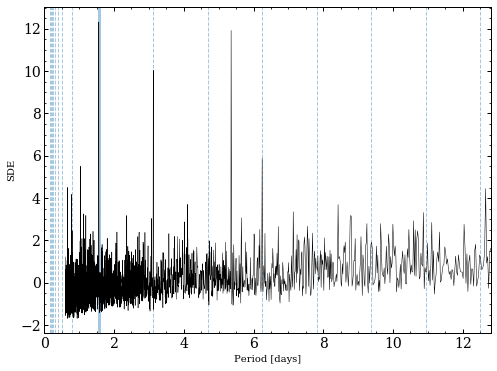

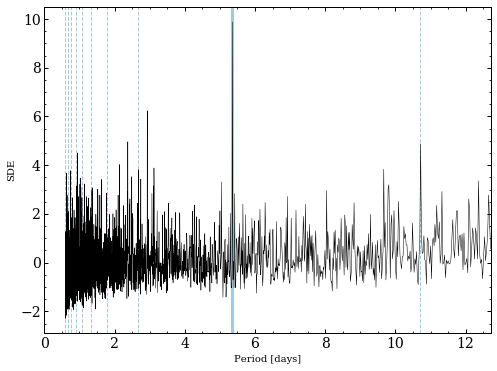

In [92]:
for s in np.unique(sectors):
    plot_sde_spectrum(results_1_dict['%i'%s])
    #plot_phasefolded_LC(results_1, ylim=(.995,1.004))

## second planet search

In [11]:
# run the tls looking for a second planet
results_2_dict = {}
bjd_2, fdetrend_2, efnorm_2, sectors_2 = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)
for s in np.unique(sectors):
    g = sectors == s
    
    p = mask_transits(bjd[g], fdetrend[g], efnorm[g], results_1_dict['%i'%s])
    bjd_2 = np.append(bjd_2, p[0])
    fdetrend_2 = np.append(fdetrend_2, p[1])
    efnorm_2 = np.append(efnorm_2, p[2])
    sectors_2 = np.append(sectors_2, np.repeat(s,p[0].size))
    
    results_2_dict['%i'%s] = run_tls(p[0], p[1], p[2], ab)

  0%|          | 0/2309 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 14329 data points, 2309 periods from 0.601 to 12.804 days
Using all 8 CPU threads


100%|██████████| 2309/2309 periods | 00:15<00:00
  2%|▏         | 162/9068 [00:00<00:05, 1618.27it/s]

Searching for best T0 for period 5.35798 days


100%|██████████| 9068/9068 [00:02<00:00, 4005.59it/s]
  0%|          | 0/2290 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 37 durations
Searching 16295 data points, 2290 periods from 0.601 to 12.714 days
Using all 8 CPU threads


100%|██████████| 2290/2290 periods | 00:18<00:00
  2%|▏         | 146/9052 [00:00<00:06, 1452.64it/s]

Searching for best T0 for period 2.93154 days


100%|██████████| 9052/9052 [00:02<00:00, 3383.92it/s]


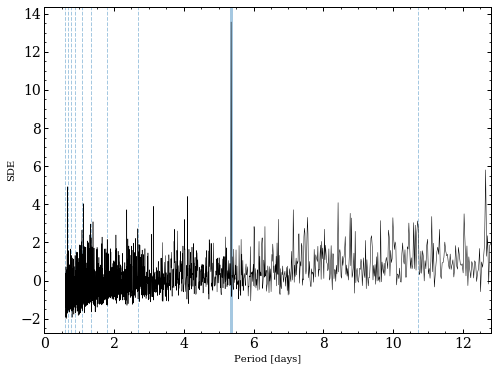

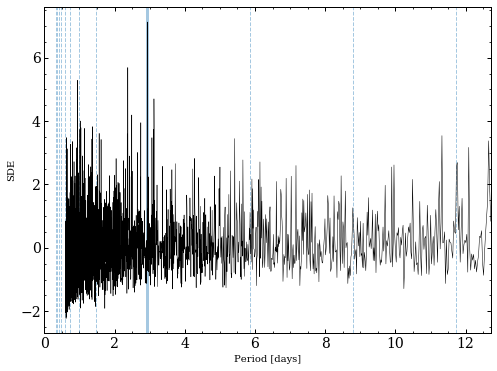

In [43]:
for s in np.unique(sectors):
    plot_sde_spectrum(results_2_dict['%i'%s])

## third planet search

In [13]:
# run the tls looking for a third planet
results_3_dict = {}
bjd_3, fdetrend_3, efnorm_3, sectors_3 = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)
for s in np.unique(sectors):
    g = sectors_2 == s
    
    p = mask_transits(bjd_2[g], fdetrend_2[g], efnorm_2[g], results_2_dict['%i'%s])
    bjd_3 = np.append(bjd_3, p[0])
    fdetrend_3 = np.append(fdetrend_3, p[1])
    efnorm_3 = np.append(efnorm_3, p[2])
    sectors_3 = np.append(sectors_3, np.repeat(s,p[0].size))
    
    results_3_dict['%i'%s] = run_tls(p[0], p[1], p[2], ab)

  0%|          | 0/2309 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 38 durations
Searching 14077 data points, 2309 periods from 0.601 to 12.804 days
Using all 8 CPU threads


100%|██████████| 2309/2309 periods | 00:14<00:00
  2%|▏         | 262/12135 [00:00<00:08, 1331.60it/s]

Searching for best T0 for period 0.66222 days


100%|██████████| 12135/12135 [00:03<00:00, 3162.65it/s]
  0%|          | 0/2290 periods | 00:00<?

Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 37 durations
Searching 15949 data points, 2290 periods from 0.601 to 12.714 days
Using all 8 CPU threads


100%|██████████| 2290/2290 periods | 00:17<00:00


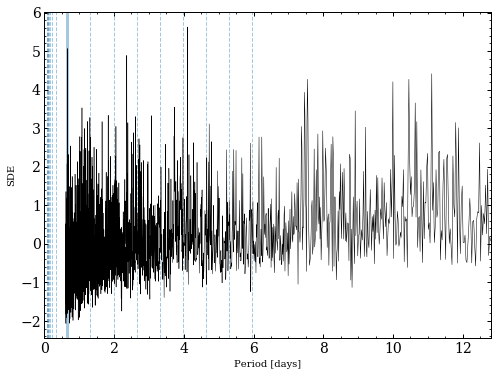

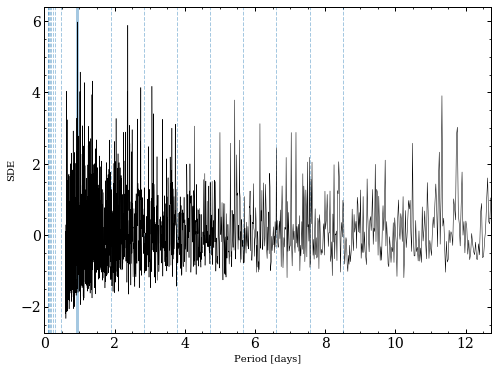

In [44]:
for s in np.unique(sectors):
    plot_sde_spectrum(results_3_dict['%i'%s])

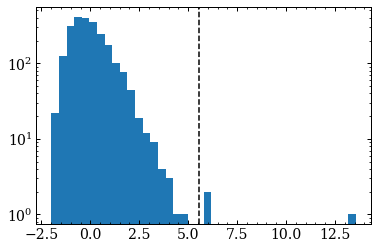

In [82]:
sde = results_2_dict['4'].power_raw
_=plt.hist(sde, bins=40, log=1)
plt.axvline(np.percentile(sde, 99.9), ls='--', color='k')

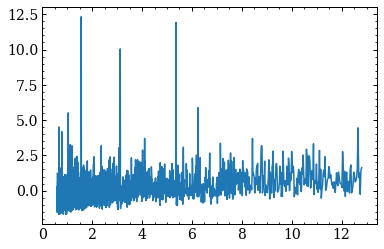

In [39]:
plt.plot(results_1_dict['4'].periods, results_1_dict['4'].power_raw)

In [78]:
phi = results_1_dict['4'].T0 + np.arange(0, results_2_dict['4'].period, results_1_dict['4'].duration/10)
chisq = np.zeros_like(phi)
g = sectors == 4
for t0 in phi:
    s = np.argsort(rvs.foldAt(bjd[g], results_1_dict['4'].period, t0) + .5)
    chisq[i] = np.sum((fdetrend[g][s] - results_1_dict['4'].model_folded_model[s])**2 / efnorm[g][s]**2)

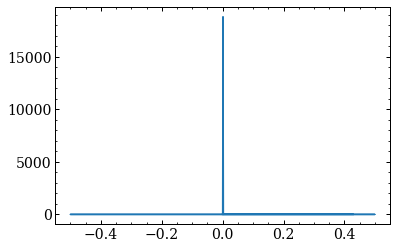

In [79]:
plt.plot(rvs.foldAt(phi, results_1_dict['4'].period, results_1_dict['4'].T0), chisq)

In [64]:
results_1_dict['4'].keys()

dict_keys(['SDE', 'SDE_raw', 'chi2_min', 'chi2red_min', 'period', 'period_uncertainty', 'T0', 'duration', 'depth', 'depth_mean', 'depth_mean_even', 'depth_mean_odd', 'transit_depths', 'transit_depths_uncertainties', 'rp_rs', 'snr', 'snr_per_transit', 'snr_pink_per_transit', 'odd_even_mismatch', 'transit_times', 'per_transit_count', 'transit_count', 'distinct_transit_count', 'empty_transit_count', 'FAP', 'in_transit_count', 'after_transit_count', 'before_transit_count', 'periods', 'power', 'power_raw', 'SR', 'chi2', 'chi2red', 'model_lightcurve_time', 'model_lightcurve_model', 'model_folded_phase', 'folded_y', 'folded_dy', 'folded_phase', 'model_folded_model'])

In [66]:
bjd[sectors==4].size

14707

In [87]:
tls.period_grid(radius, mass, (bjd.max()-bjd.min()), period_max=100)

array([99.99623478, 99.98947867, 99.98272317, ...,  0.1746223 ,
        0.17462087,  0.17461945])